# Project 1: Milestone 2 - White Paper
### DSC680-T301 Applied Data Science
### Joshua Greenert
### 3/18/2023

## Business Problem

Businesses and individuals alike invest in housing to provide for their family, or to rent out their property to gain residual income.  According to the Internal Revenue Service, in 2018 approximately 10.3 million individual filers reported they were owners of rental properties while owning 1.72 properties on average (Pew Research Center, 2021).  Throughout this project, we will attempt to discover whether these owners should be considering selling their investments, whether their homes will be massively underwater, and whether the housing market will remain stable for existing and new investors.  We will also be attempting to gain insight for millions of homeowners of whom may be worried during these tumultuous times.

## Background and History

The housing market has always been a crucial aspect of the economy, and the volatility and unpredictability make it a significant challenge for any investor to make informed decisions on buying, selling, or renting properties.  Historically speaking, the housing market has experienced significant fluctuations, with the most notable being the housing bubble and subsequent crash in 2008.  This crash led to a severe recession, with many homeowners losing their homes, and a market that took several years to recover.

Afterwards, the housing market made a gradual recovery, with prices increasing year after year.  However, the Covid-19 pandemic has had a significant impact on the market, creating uncertainty and instability for homeowners, buyers, and sellers alike.  In this context, accurate predictions of future housing prices are essential for making informed decisions.  Machine learning models can assist in forecasting future housing prices by analyzing trends and patterns in historical data, providing insights for investors and homeowners.

In this white paper, we will explore the potential of machine learning models to predict future housing prices while examining their accuracy, reliability, and limitations.  Additionally, we will also explore the implications of the findings for homeowners, investors, and the housing market for future viability.

## Data Preparation

In [1]:
# Set some required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Pull in the data.
df_housing = pd.read_csv('Housing.csv')
df_hpi = pd.read_csv('HPI_master.csv')
df_sale_prices_states = pd.read_csv('Sale_Prices_State.csv')

df_state_stats = pd.read_excel('state_statistics_for_download.xls')

### State Stats Dataset

In [2]:
# Fix the state stats dataframe.
# Correct the row headers for the state stats.
df_state_stats.columns = df_state_stats.iloc[3]

#remove first row from DataFrame
df_state_stats = df_state_stats[4:]

# Remove all values of US from the State column
df_state_stats = df_state_stats[df_state_stats['State'] != 'US']

# Remove the rows with Q2, Q3, and Q4 data.
df_state_stats = df_state_stats[~df_state_stats['Year-Quarter'].str.contains('Q[234]')]

In [3]:
# Loop through the dataframe and replace each year-quarter with an actual date object.
import datetime

for index, row in df_state_stats.iterrows():
    year = int(row['Year-Quarter'][0:4])
    date = datetime.date(year, 1, 1)
    df_state_stats.at[index,'Year-Quarter'] = date

# Show the head to confirm working
df_state_stats.head(3)

3,State,Year-Quarter,Average Price,Median Price
46,AK,2000-01-01,159887,148406
50,AK,2001-01-01,168500,155637
54,AK,2002-01-01,175754,161283


### Housing Dataset

In [4]:
# Fix the area codes so that they are strings and have 0's at the beginning if the number is less than 5 digits.
for index, row in df_housing.iterrows():
    if(len(str(row['area'])) < 5):
        zipCode = "0" + str(row['area'])
        df_housing.at[index,'area'] = zipCode
    else:
        df_housing.at[index,'area'] = str(row['area'])
        
df_housing.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,07420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,08960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,09960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


### HPI Dataset

In [5]:
# Remove all rows with level that is not equal to state.
df_hpi = df_hpi[df_hpi['level'] == 'State']

# Remove all the periods not equal to 1
df_hpi = df_hpi[df_hpi['period'] == 1]

# Update the year to be a date; otherwise visuals won't work right.
for index, row in df_hpi.iterrows():
    year = int(row['yr'])
    date = datetime.date(year, 1, 1)
    df_hpi.at[index,'yr'] = date

# filter out any rows where hpi_flavor is not equal to all-transactions, and traditional data for hpi-type
df_hpi = df_hpi[df_hpi['hpi_flavor'] == "all-transactions"]
df_hpi = df_hpi[df_hpi['hpi_type'] == "traditional"]

# Drop all columns not needed
df_hpi = df_hpi.drop(['period', 'index_sa', 'frequency', 'level', 'hpi_flavor','hpi_type'], axis = 1)

# Show the head to confirm working
df_hpi.head(3)

,place_name,place_id,yr,index_nsa
67915,Alaska,AK,1975-01-01,62.05
67919,Alaska,AK,1976-01-01,71.34
67923,Alaska,AK,1977-01-01,78.24


### Sale Price States Dataset

In [6]:
# Remove all columns besides the state name and most recent pricing column with all values.
df_sale_prices_states = df_sale_prices_states.loc[:, ['RegionName', '2020-02']]

# Create a dict to map over.
state_abbr = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# create new column with state abbreviations
df_sale_prices_states['State'] = df_sale_prices_states['RegionName'].map(state_abbr)

df_sale_prices_states.head(3)

,RegionName,2020-02,State
0,California,524400,CA
1,Texas,239900,TX
2,New York,324800,NY


## Visualizations

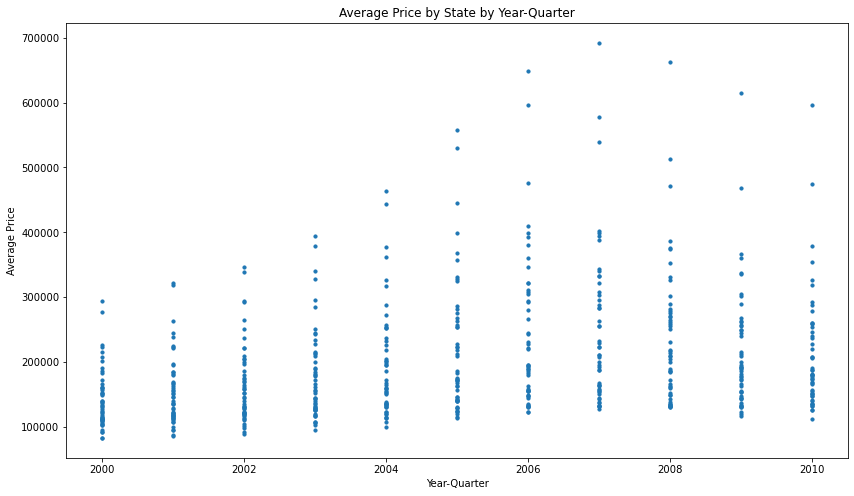

In [7]:
# Create some visualizations with state stats dataframe.
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))
plt.scatter(df_state_stats['Year-Quarter'], df_state_stats['Average Price'], s=10)
plt.xlabel('Year-Quarter')
plt.ylabel('Average Price')
plt.title('Average Price by State by Year-Quarter')
plt.show()

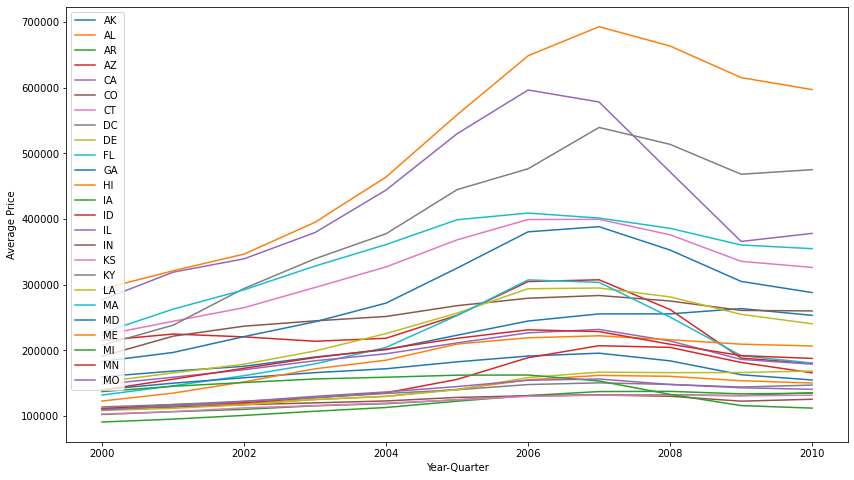

In [8]:
# Show a line graph by grouped state data.
# Group the data by state
grouped = df_state_stats.groupby('State')

# Create a line plot for each state
plt.figure(figsize=(14, 8))

# Show only half the data at a time (50 states at once is wild)
i = 0
for state, group in grouped:
    if i < 25:
        plt.plot(group['Year-Quarter'], group['Average Price'], label=state)
    else:
        break
    i += 1

# Add axis labels
plt.legend()
plt.xlabel('Year-Quarter')
plt.ylabel('Average Price')

# Show the plot
plt.show()

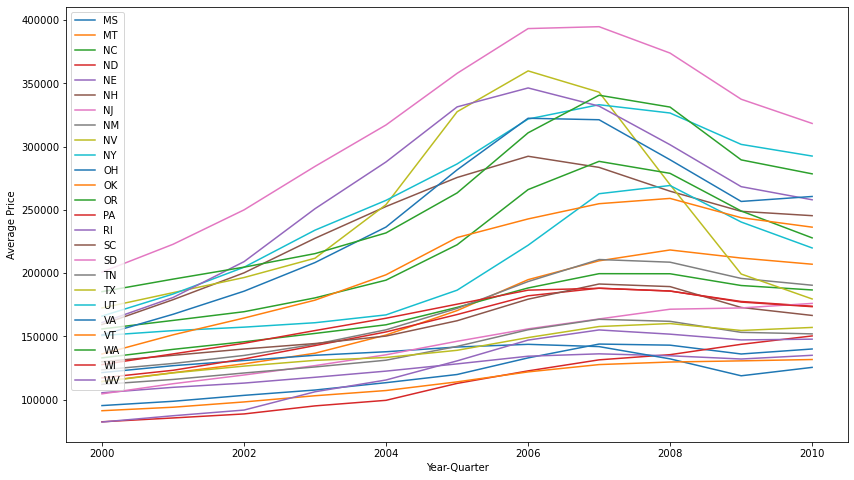

In [9]:
# Create a line plot for the second 25 states
plt.figure(figsize=(14, 8))

i = 0
for state, group in grouped:
    if i >= 25 and i < 50:
        plt.plot(group['Year-Quarter'], group['Average Price'], label=state)
    elif i >= 50:
        break
    i += 1

# Add axis labels
plt.legend()
plt.xlabel('Year-Quarter')
plt.ylabel('Average Price')

# Show the plot
plt.show()

In [10]:
# Calculate the percentage change for each state
df_change = df_state_stats.groupby('State').apply(lambda x: x['Average Price'].pct_change().iloc[-1]).reset_index(name='pct_change')

# Sort the states based on the percentage change
df_sorted = df_change.sort_values(by='pct_change', ascending=False)

# Get the top 5 states with the highest percentage change
top_states = df_sorted['State'].head(5).tolist()

print('Top 5 states with highest percentage change:')
print(top_states)

Top 5 states with highest percentage change:
['OH', 'ND', 'CA', 'IA', 'MS']


From the data presented above, we can see a drastic spike for quite a few states around the 2007-2008 timeline.  This was expected as the impact of the housing bubble crisis had a significant impact on homeowners and real-estate costs.  However, we can see some obvious outliers.  Ohio, North Dakota, California, Iowa, and Mississippi appear to have the highest percent change with Indiana, Nebraska, South Dakota, Kentucky, and Texas completing the top 10.  Since these locations have the highest fluctuations, it may make sense for them to have the biggest impact for future housing market crisises.  Let's dig into the other datasets to see what else can be determined.

In [ ]:
# Create some visualizations with the housing dataset
import plotly.express as px
from uszipcode import SearchEngine
import geopy
from geopy.geocoders import Nominatim

# Search and update the zip codes to include states in the dataframe.
search = SearchEngine()

# Define a function to get the state
def get_state(zipcode):
    result = search.by_zipcode(zipcode)
    if result is None:
        return "N/A"
    return result.state

# set the states into the dataframe.
df_housing['State'] = df_housing['area'].apply(get_state)

# filter out any rows where State is missing
df_housing = df_housing[df_housing['State'] != "N/A"]

# group the dataframe by area
grouped_housing_df = df_housing.groupby(['area', 'State']).size().reset_index(name='counts')

# create a geolocator object using Nominatim
geolocator = Nominatim(user_agent="my_app")

# define a function to get the latitude and longitude for a given zip code
def get_lat_lon(zipcode):
    location = geolocator.geocode(zipcode)
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# apply the get_lat_lon function to the 'area' column to create new columns for latitude and longitude
grouped_housing_df[['Latitude', 'Longitude']] = grouped_housing_df['area'].apply(get_lat_lon).apply(pd.Series)

# filter out any rows where latitude or longitude is missing
grouped_housing_df = grouped_housing_df.dropna(subset=['Latitude', 'Longitude'])

# create a spatial chart using Plotly
fig = px.scatter_geo(grouped_housing_df, lat='Latitude', lon='Longitude', hover_name='State', scope='usa', color='State')
fig.update_layout(title='Housing Data Spatial Chart', title_x=0.5, title_y=0.89)
fig.show()

This code above is no longer working after installing snappy for another class.  My guess here is that if snappy is installed, pyplot attempts to use snappy for compression in the older libraries where it was supported.  The resulting chart was a spatial chart that shows only data points in the northeast portion of the united states.  This means PA, NJ, NY, and MA were present, but no other states were which made it a problem for future accuracy checks for updated data.

The process performed here was to check our dataset to ensure that the data being used was encompassing all of the United States.  Instead, we found that the data stored within only contains data that covers the North-East states.  The objective of this dataset was to use as an expectation of current prices.  However, this data only contains a portion for what we anticipate to use it for.  Therefore, another dataset is required to have a baseline of the state's average.

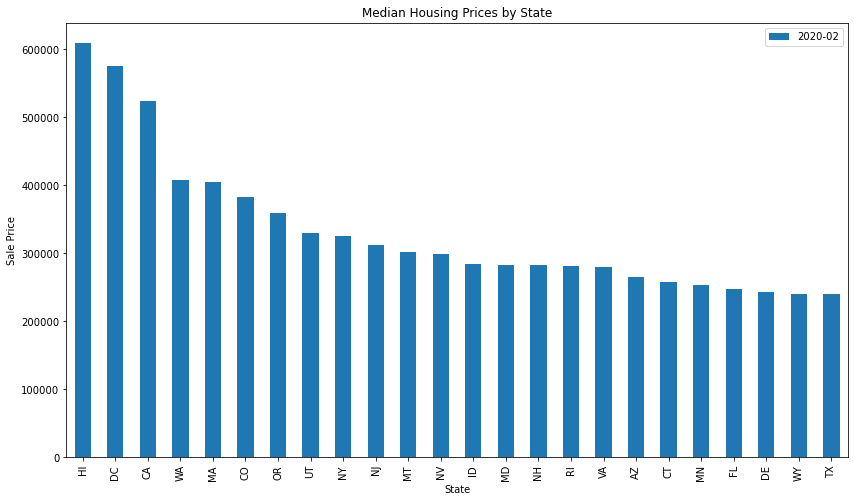

In [11]:
# Create some visualizations with the prices per state replacement dataset.
# Sort the dataframe prior to splitting
df_sale_prices_states = df_sale_prices_states.sort_values(by=['2020-02'], ascending=False)

# Split the data in two sets to show the price by state.
df_states1 = df_sale_prices_states.iloc[:len(df_sale_prices_states)//2]
df_states2 = df_sale_prices_states.iloc[len(df_sale_prices_states)//2:]

# Plot the data
ax = df_states1.plot(kind='bar', x='State', y='2020-02', figsize=(14, 8))
ax.set_ylabel('Sale Price')
ax.set_title('Median Housing Prices by State')
plt.show()

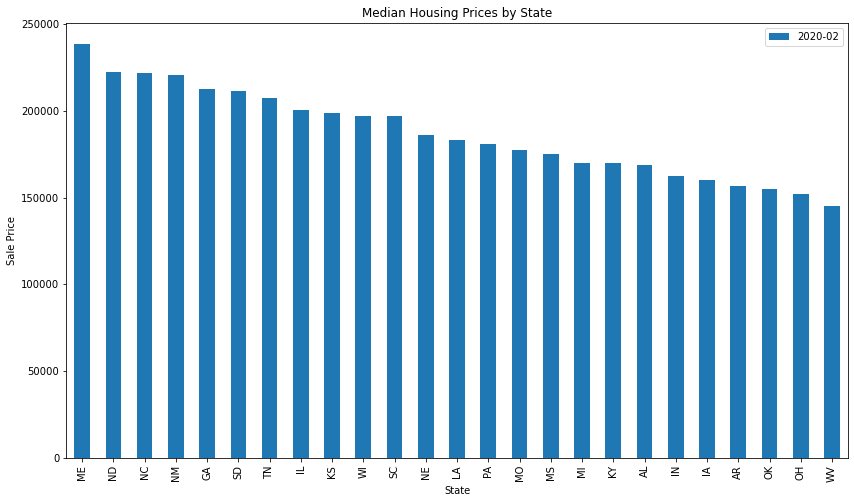

In [12]:
# Plot the remaining data
ax = df_states2.plot(kind='bar', x='State', y='2020-02', figsize=(14, 8))
ax.set_ylabel('Sale Price')
ax.set_title('Median Housing Prices by State')
plt.show()

The new dataset appears more viable as a baseline for the current price scale.  We can see that reflected in both graphs as we compare them to the previous line charts above.  For example, Hawaii's average home cost is grossly over-valued in the range of $600,000!  Since our data in the graphs above end at the year 2010, this can provide a check to tell if our model is performing correctly.  If we are close to these actual figures, then we'll know that the model has fairly close predictions.

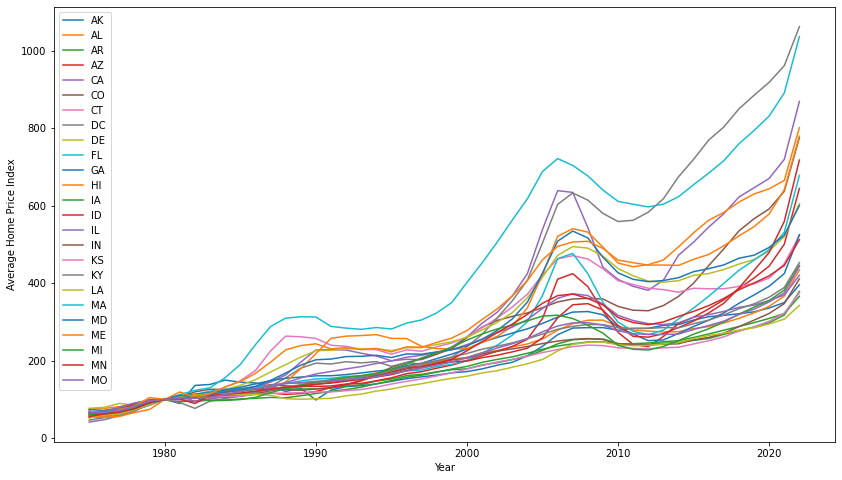

In [13]:
# Create visualizations for the hpi dataframe.

# Group the data by place_id
grouped_hpi = df_hpi.groupby('place_id')

# Create a line plot for each state
plt.figure(figsize=(14, 8))

# Show only half the data at a time (50 states at once is wild)
i = 0
for state, group in grouped_hpi:
    if i < 25:
        plt.plot(group['yr'], group['index_nsa'], label=state)
    else:
        break
    i += 1

# Add axis labels
plt.legend()
plt.xlabel('Year')
plt.ylabel('Average Home Price Index')

# Show the plot
plt.show()

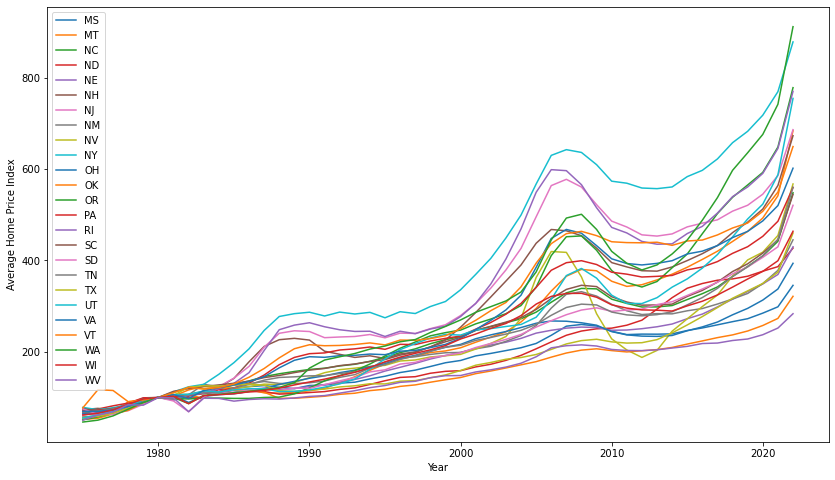

In [14]:
# Create a line plot for the second 25 states
plt.figure(figsize=(14, 8))

i = 0
for state, group in grouped_hpi:
    if i >= 25 and i < 50:
        plt.plot(group['yr'], group['index_nsa'], label=state)
    elif i >= 50:
        break
    i += 1

# Add axis labels
plt.legend()
plt.xlabel('Year')
plt.ylabel('Average Home Price Index')

# Show the plot
plt.show()

Now, we can see that we have a solid baseline for the pricing data from 1980 to 2020 from the HPI dataset.  Additionally, we can clearly see the impact that took place for 2020 where housing prices skyrocketed.  Based on the collected data for purchases, we can see that there was a massive dip in the curve around the 2008 time period which coincides with our current understanding of the housing market.  We can also see the recovery that took about four years to begin.  

## Methods

The initial goal of this project was to use the Random Forest Regression (RFR) and the Autoregressive Integrated Moving Average (ARIMA) algorithms to determine the best and/or closest model for predictions moving forward.  Afterwards, the ARIMA model was created to predict the next 10 years of Home Price Index (HPI) by state to attempt to meet the goal of this project.

## Analysis

After performing a test with the random forest regression model on predictions, it was clear that the model wasn't accurate enough to predict the values correctly, and would have provided values that greatly exceeded the expectation of our initial assumption.  After checking a few methods for accuracy, a linear regression model was attempted to determine if it could provide a closer prediction than the former.  Despite the later research confirming that neither of these models are the preferred option for the goal, the linear regression model proved to have a greater ability to predict than the random forest regression. Nevertheless, the prediction for the Mean Squared Error (MSA) was far too high to be useful to any sort of degree. 

However, the ARIMA model was able to predict values for the HPI by year by state that were relatively feasible.  Using California as an example, the values trended downwards over the next few years, then recovered thereafter.  The initial assumption held was that certain states would have higher volatility and, therefore, would have a higher expecation to drop/rise based on the future price indexes.  This value or expectation held true in the model's predictions mostly.  Other data points, such as WV and MO, showed a continuous drop that continued over the next 10 years with no expectation of recovery; this is believed to be an error with the model that would need to be corrected prior to deployment.  Additional testing and alterations of the model are still required.

## Conclusion

The model is almost ready, but has some minor modifications that will be needed before it can be deployed properly.  The predictions in the model appear to indicate heavy-volatile states may have a significant drop in the coming years, while other states without heavy volatility were somewhat unimpacted.  There are several factors that are not accounted for within this model (i.e. banks failing, dollar price index, etc.), but the model predictions are fairly close.  Additional modifications will be needed to "clean up" the model and it's performance to be ready for full release.

## Assumptions

Assumptions within this project are that the market, overall, won't crash entirely.  If we see the S & P 500 (ticker called SPY) drop below 330 in the next coming months, the impact of that drop may not be accounted for and invalidate the results found within this project.  Moveover, if high-volatile states behavior in a way that is not matching previous data, the expectations of this model will also be invalidated.

## Limitations

The model used relies on the use of a dataset for HPI indexes.  Therefore, the actual price value of the homes are not provided and, instead, the home price index for that state.  Additionally, each state has areas that may be impacted by other factors that were not anticipated, so each area may fall/rise in a greater amount based on the region and its investors in that region respectively.

## Challenges

One of the biggest challenges with the ARIMA model was implementing proper seasonality.  The initial build of the model resulted in predictions that were constantly going up.  Based on the data from the HPI index of each state, this isn't entirely irrational since the HPI indexes for each state begin in the dataset around 30 to 50 points.  If the seasonality is over-estimated, then the model expects a longer recession period than what will actually happen.  Alternatively, if the seasonality is under-estimated, then the model will expect a shorter recession than what will actually happen for high-volatity states.

## Future Uses and Additional Applications

Future uses of this model can be used to anticipate future performance of the housing market as a whole for the United States.  Likewise, this can be modified to be used with other countries to anticipate their future values in a similar fashion to extend that data to homeowners and investors alike.

## Recommendations

Additional modifications are required before this model is ready for deployment.  We will need to compare the data against current prices per year, provided by the Zillow dataset shown above, to tweak the values and ensure that they match what we have with the given predictions.  This step will ensure that our model is performant while ensuring that the predictions are closer than what we are currently given.

## Implementation Plan

Ideally, the implementation plan would setting up the model in a web environment where routine pulls are made from the Federal Housing Financy Agency (FHFA) to ensure that the data is constantly updated.  This would allow the model to continuously be provided with updated information while allowing the model to update the forecasted predictions to later years, as they become available.  

## Ethical Assessment

The main ethics to consider in this project revolve around the finance sector.  These predictions may eventually be fairly accurate to some degree, but they cannot be construed as financial advice.  This message must be provided when regarding any discussions or estimations made over finances, or when finances are discussed related to investors or prospective clients.

## Appendix

- ARIMA - Autoregressive Integrated Moving Average
- FHFA - Federal Housing Finance Agency
- HPI - Home Price Index
- SPY - S & P 500 index fund
- RFR - Random Forest Regression

## 10 Questions From the Audience

1. How accurate are these models/predictions?
    1. These model and predictions are based on the current data provided by the the Federal Housing Finance Agency.  Based on the prices listed from Zillow for purchase-only sold locations in 2022, the data for most states appear within the median range provided.
2. Why would you use an ARIMA model over LSTM models?
    1. A Long Short-Term Memory (LSTM) model was attempted, but the results were far worse with the predictions than the ARIMA model as the values were expected to only go up with all states.  If this were a wallstreetbets subreddit, i'd have used that instead.
3. Why would Zillow data be accurate in regards to current average pricing?
    1. Zillow is one of the largest sites used to view and purchase homes in the US.  The collected through that medium would include outliers while also including a significant amount of prices that homes actually sold for.
4. Who benefits from seeing these predictions more?
    1. Any investor benefits from seeing these predictions and their expected results.  A savvy investor who can utilize all of the tools within their arsenal is setting themselves up for a proper amount of skepticism.
5. Will these predictions, when positive, make housing prices rise or vice versa?
    1. It's unlikely that these predictions will affect housing market prices, especially since the current model has some errors.  In all actuallity, these predictions shouldn't impact the price of homes, but assist to confirm people's interest in buying them.
6. Why would SPY be a significant indicator that the results of this data would be impacted?
    1. SPY (or the S & P 500) is a mass-collection of stocks within the hospitality, technology, and healthcare industry.  If SPY were to dip significantly downward, it could lead to a domino effect of margin calls and forced-selling within the housing market industry.
7. Why would certain regions within each state be possible to not meet the predictions?
    1. Certain regions may be more prominent than others within the state.  For instance homes outside of Louisville Kentucky may not cost nearly as much as homes within Louisville due to their proximity to downtown areas, resources, etc.
8. Could these predictions help to estimate the possibility of future stock market crashes?
    1. It's possible that these predictions may assist in seeing future curves within the housing market, which may indicate a dip within the stock market, but that's completely speculation and unlikely.
9. Does this mean that people should expect a recovery time period of about four years for each time we see a massive dip in the housing market?
    1. There are no hard and fast rules about financial recovery.  Any amount of time stated or shown throughout this project is not financial advice, nor is it guidance on when would be the best time to sell investments.  Please use caution when making any major financial decisions and consult a financial expert.
10. What are some steps the country can take to avoid potential crashes in the future?
    1. That's tough to say.  The reason they rise, in most cases, is due to demand and people willing to pay the price that others are offering their home for.  Would it make sense for the government to set a limit on a capitalistic society?  I certainly don't think so, but the government is the one hosting this data, and they can show a view similar to the ones that I have to provide more insight to investors.

## References

Federal Housing Finance Agency. (2022). House Price Index Datasets [Data set]. Retrieved from https://www.fhfa.gov/DataTools/Downloads/Pages/House-Price-Index-Datasets.aspx

Mooney, P. T. (2021). Zillow House Price Data [Data set]. Kaggle. https://www.kaggle.com/datasets/paultimothymooney/zillow-house-price-data?select=Sale_Prices_State.csv

Parker, K., & Stepler, R. (2021, August 2). As national eviction ban expires, a look at who rents and who owns in the U.S. Pew Research Center. https://www.pewresearch.org/fact-tank/2021/08/02/as-national-eviction-ban-expires-a-look-at-who-rents-and-who-owns-in-the-u-s/

Yasser, H. (2020). Housing Prices Dataset. Kaggle. Retrieved February 14, 2023, from https://www.kaggle.com/datasets/yasserh/housing-prices-dataset
